In [8]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

seed = 42
np.random.seed(seed=seed)
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 300, 3000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.random.choice(np.arange(1, 301), size=150, replace=False)
indices = [np.abs(x_dense.flatten() - x).argmin() for x in integer_points]
y_integers = y_dense[indices]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#2ca02c',]

fig.add_trace(go.Scatter(
    x=integer_points,
    y=y_integers,
    mode='markers',
    name='被选点',
    marker=dict(
        color=colors[0],
        size=8,
        line=dict(width=1, color='DarkSlateGrey')
)))

fig.update_layout(
    title='高斯过程曲线与选点结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='标志',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [9]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: 0.001000000000005179
负特征值数量: 0


In [10]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern

seed = 42
np.random.seed(seed=seed)

# 定义二维核函数
kernel_2d = ConstantKernel(25.0) * Matern(length_scale=10.0, nu=2.5) + WhiteKernel(1e-3)
gp_2d = GaussianProcessRegressor(kernel=kernel_2d)

# 创建二维网格点
x1_range = np.linspace(1, 51, 50)  # 第一个维度
x2_range = np.linspace(1, 51, 50)  # 第二个维度
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T  # 形状为 (2500, 2)

# 从二维高斯过程中采样曲面
y_surface = gp_2d.sample_y(X_grid, n_samples=1, random_state=seed).flatten() + 70
Y = y_surface.reshape(X1.shape)  # 重塑为网格形状

# 在二维空间中随机选择150个点
n_points = 150
random_points = np.column_stack([
    np.random.choice(x1_range, size=n_points),
    np.random.choice(x2_range, size=n_points)
])

# 找到这些随机点在网格中的最近邻索引
def find_nearest_indices(points, grid_points):
    indices = []
    for point in points:
        distances = np.linalg.norm(grid_points - point, axis=1)
        indices.append(np.argmin(distances))
    return indices

indices = find_nearest_indices(random_points, X_grid)
y_points = y_surface[indices]

# 计算这100个点之间的协方差矩阵
cov_matrix = kernel_2d(random_points)  # 形状为 (100, 100)

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)

# 创建等高线地形图
fig = go.Figure()

# 添加等高线图
fig.add_trace(go.Contour(
    x=x1_range,
    y=x2_range,
    z=Y,
    colorscale='Viridis',
    contours=dict(
        coloring='heatmap',
        showlabels=True,
        labelfont=dict(size=12, color='white')
    ),
    name='GP曲面',
    colorbar=dict(title="函数值")
))

# 添加采样点
fig.add_trace(go.Scatter(
    x=random_points[:, 0],
    y=random_points[:, 1],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        line=dict(width=2, color='darkred')
    ),
    name='采样点',
    text=[f'值: {val:.2f}' for val in y_points],
    hoverinfo='text+x+y'
))

fig.update_layout(
    title='高斯过程曲面等高线图与采样点',
    xaxis_title='X1 维度',
    yaxis_title='X2 维度',
    template='plotly_white',
    width=1000,
    height=800,
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    margin=dict(r=150)
)

fig.show()

# 输出结果信息
print(f"生成的均值向量形状: {y_points.shape}")
print(f"协方差矩阵形状: {cov_matrix.shape}")
print(f"相关性矩阵形状: {corr_matrix.shape}")
print(f"均值范围: [{y_points.min():.3f}, {y_points.max():.3f}]")
print(f"曲面值范围: [{Y.min():.3f}, {Y.max():.3f}]")

生成的均值向量形状: (150,)
协方差矩阵形状: (150, 150)
相关性矩阵形状: (150, 150)
均值范围: [59.923, 78.614]
曲面值范围: [59.177, 79.480]


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000040-0.000000j (应>0)
=== 相关性统计 ===
平均相关性: 0.1653
最大相关性: 1.0000
最小相关性: 0.0000
相关性 > 0.5的比例: 0.1131
相关性 > 0.8的比例: 0.0382


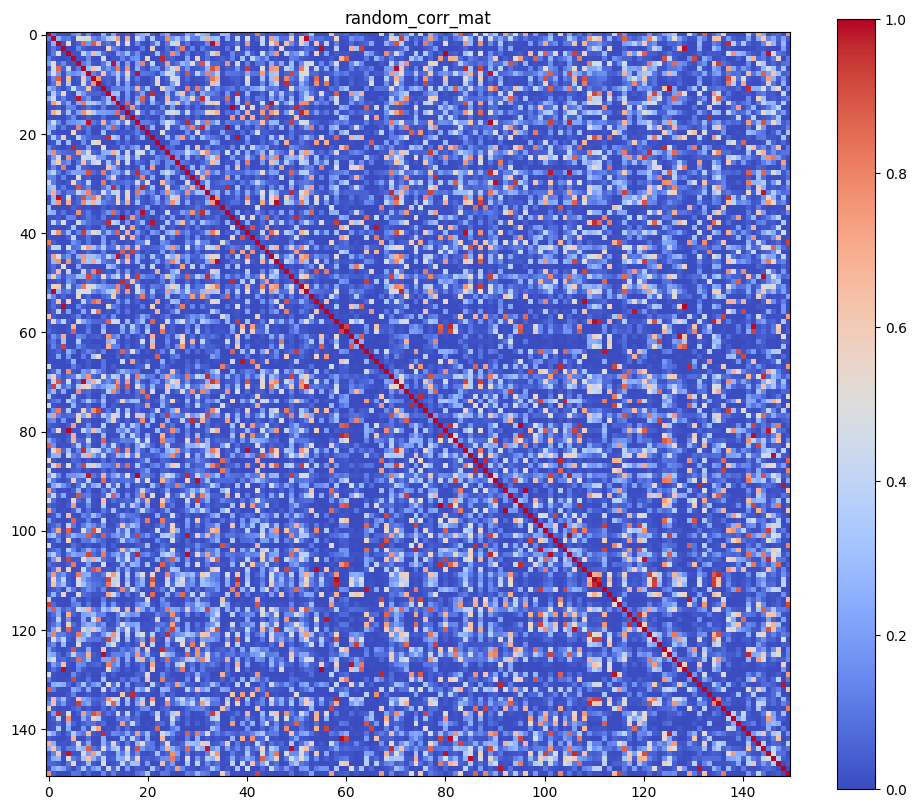

In [11]:
import matplotlib.pyplot as plt
# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

print("=== 相关性统计 ===")
print(f"平均相关性: {np.mean(corr_matrix):.4f}")
print(f"最大相关性: {np.max(corr_matrix):.4f}")
print(f"最小相关性: {np.min(corr_matrix):.4f}")
print(f"相关性 > 0.5的比例: {np.sum(corr_matrix > 0.5) / (n_points * n_points):.4f}")
print(f"相关性 > 0.8的比例: {np.sum(corr_matrix > 0.8) / (n_points * n_points):.4f}")
# 可视化矩阵
plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
plt.title("random_corr_mat")
plt.show()

In [12]:
import numpy as np

# 假设已有 mu 和 correlation_matrix
# mu = ... (形状: (100,))
# correlation_matrix = ... (形状: (100, 100))

# 1. 找到mu中最小的8个值的索引
min_indices = np.argsort(y_integers)[:8]
print("最小的8个值的索引:", min_indices)
print("最小的8个值:", y_integers[min_indices])

# 2. 提取这8个值对应的相关性矩阵子集
correlation_submatrix = corr_matrix [min_indices, :][:, min_indices]
print("8个最小点对应的相关性矩阵形状:", correlation_submatrix.shape)

# 3. 输出结果
print("\n=== 最小的8个值 ===")
for i, idx in enumerate(min_indices):
    print(f"索引 {idx}: 值 = {y_integers[idx]:.6f}")

print("\n=== 对应的相关性矩阵 ===")
print("矩阵形状:", correlation_submatrix.shape)
print("相关性矩阵:")
for i in range(correlation_submatrix.shape[0]):
    print(" ".join([f"{correlation_submatrix[i,j]:.6f}" for j in range(correlation_submatrix.shape[1])]))

最小的8个值的索引: [135  55  63  26  69 134  70   7]
最小的8个值: [59.98422742 60.49123023 61.03365687 61.05306372 61.23334316 61.33887586
 61.37576955 61.75749673]
8个最小点对应的相关性矩阵形状: (8, 8)

=== 最小的8个值 ===
索引 135: 值 = 59.984227
索引 55: 值 = 60.491230
索引 63: 值 = 61.033657
索引 26: 值 = 61.053064
索引 69: 值 = 61.233343
索引 134: 值 = 61.338876
索引 70: 值 = 61.375770
索引 7: 值 = 61.757497

=== 对应的相关性矩阵 ===
矩阵形状: (8, 8)
相关性矩阵:
1.000000 0.166706 0.196850 0.147182 0.401407 0.799522 0.137661 0.159435
0.166706 1.000000 0.879270 0.087072 0.024907 0.271697 0.031632 0.036935
0.196850 0.879270 1.000000 0.159435 0.033907 0.355271 0.057893 0.066865
0.147182 0.087072 0.159435 1.000000 0.093208 0.280645 0.630367 0.658678
0.401407 0.024907 0.033907 0.093208 1.000000 0.263110 0.181758 0.198527
0.799522 0.271697 0.355271 0.280645 0.263110 1.000000 0.204541 0.236165
0.137661 0.031632 0.057893 0.630367 0.181758 0.204541 1.000000 0.991384
0.159435 0.036935 0.066865 0.658678 0.198527 0.236165 0.991384 1.000000


验证结果:
方差范围: 25.66-142.44 (目标: 25-144)
最小特征值: 0.001644 (应>0)


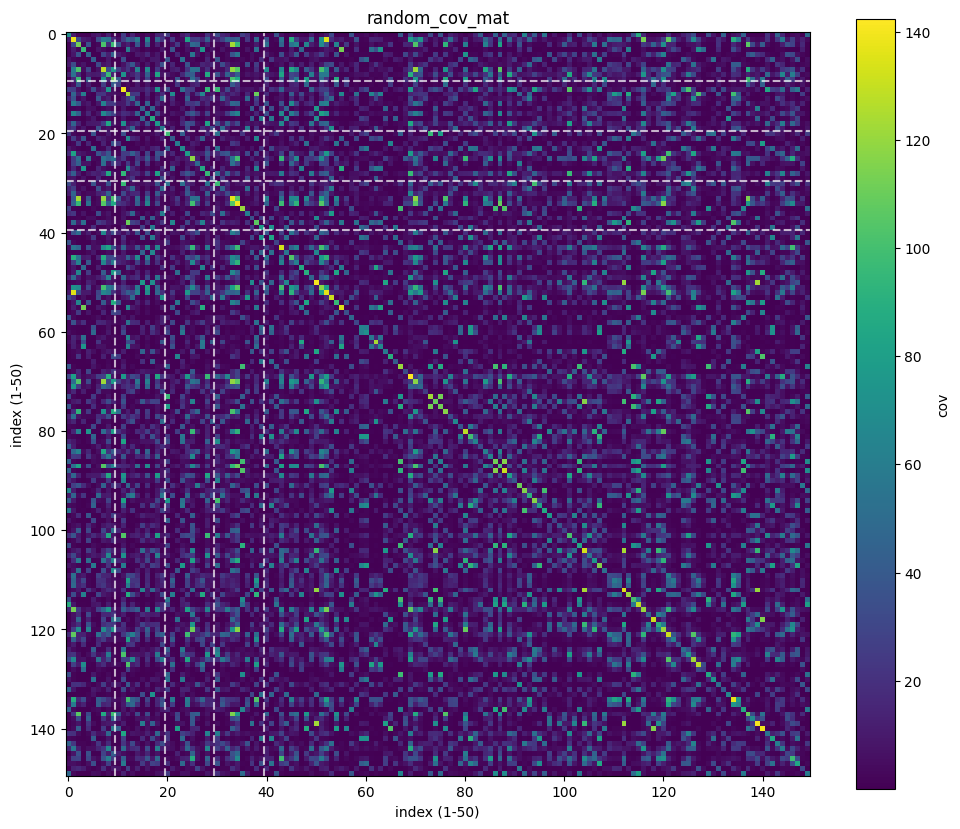

In [13]:
# 随机分配噪声
np.random.seed(seed)  
variances = np.random.uniform(low=25, high=144, size=150)
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('random_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [14]:
variances

array([ 69.57027414, 138.13500246, 112.10727908,  96.24035962,
        43.56621821,  43.56334792,  31.91194985, 128.07496135,
        96.5326864 , 109.26063676,  27.44955482, 140.41927241,
       124.06067426,  50.26835417,  46.6371711 ,  46.82513667,
        61.20482691,  87.44601536,  76.40145722,  59.65626768,
        97.81049447,  41.59976942,  59.76521318,  68.59705935,
        79.27232812, 118.43593941,  48.76118008,  86.19389817,
        95.49733369,  30.52759911,  97.29783738,  45.29237072,
        32.74113957, 137.91737893, 139.91021194, 121.19928443,
        61.24903853,  36.62298157, 106.42373015,  77.37814676,
        39.52254995,  83.9260523 ,  29.09223401, 133.20912785,
        55.79481781, 103.84015184,  62.09361805,  86.88809452,
        90.05852324,  46.99768021, 140.3805707 , 117.24080598,
       136.80037405, 131.4844547 ,  96.15009748, 134.70303397,
        35.53060774,  48.32196063,  30.38204738,  63.71430936,
        71.25259747,  57.29053478, 123.61976359,  67.45